In [ ]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Install required dependancies
!pip install odfpy

     |████████████████████████████████| 717 kB 4.3 MB/s 
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160693 sha256=02857d18adaa01ed22392838c5c2288b09ca823801ddda22f24d6f016a9c87ca
  Stored in directory: /root/.cache/pip/wheels/e2/f4/5d/a68c656235d33455a1d0f78e877acddfa006907a6d52d7e6ee
Successfully built odfpy


In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
# Read the data
df = pd.read_excel('/content/drive/MyDrive/email_classification/data/Predictive - Case study - Copy.ods')
df.head()

,Customer,Label,Chain
0,Jakson,High,We have observed low performance in Vikram sol...
1,NaN,NaN,Please share the complete wet leakage current ...
2,Marco Rau,High,Please find attached details of the request re...
3,Mateo Marus,High,"Hello, I am sending you the files related to i..."
4,Malwa,High,Please find enclosed a notice from Malwa Solar...


In [ ]:
# Shape of the dataframe
df.shape

(146, 3)

In [ ]:
# Check missing values if any
df.isnull().sum()

Customer    16
Label       12
Chain       15
dtype: int64

In [ ]:
# Drop missing values
df = df.dropna().reset_index(drop=True)
df.shape

(123, 3)

In [ ]:
df.head()

,Customer,Label,Chain
0,Jakson,High,We have observed low performance in Vikram sol...
1,Marco Rau,High,Please find attached details of the request re...
2,Mateo Marus,High,"Hello, I am sending you the files related to i..."
3,Malwa,High,Please find enclosed a notice from Malwa Solar...
4,UjaasRajgarh,High,Hope you are safe and healthy in this unpreced...


In [ ]:
# Pre-process the text
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Convert to lower case
    sentence = sentence.lower()

    return sentence

df.Chain = df.Chain.apply(preprocess_text)

In [ ]:
df.head()

,Customer,Label,Chain
0,Jakson,High,we have observed low performance in vikram sol...
1,Marco Rau,High,please find attached details of the request re...
2,Mateo Marus,High,hello am sending you the files related to insu...
3,Malwa,High,please find enclosed notice from malwa solar p...
4,UjaasRajgarh,High,hope you are safe and healthy in this unpreced...


In [ ]:
df.Label.unique()

array(['High', 'HIgh', 'Medium', 'Low'], dtype=object)

In [ ]:
# Replace HIgh with High
df.Label = df.Label.str.replace('HIgh', 'High')
df.Label.unique()

array(['High', 'Medium', 'Low'], dtype=object)

Text(0.5, 1.0, 'Distribution of labels in our data')

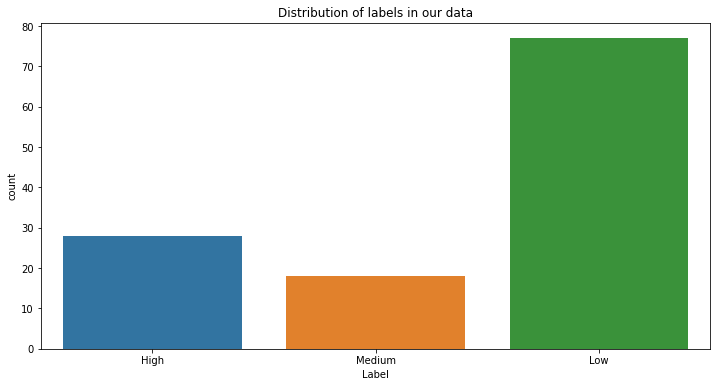

In [ ]:
# Count plot for Label
plt.figure(figsize=(12,6))
sns.countplot(df.Label)
plt.title('Distribution of labels in our data')

Classes/labels are imbalanced in the our data.

### BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 39.2 MB/s 
     |████████████████████████████████| 895 kB 39.9 MB/s 
     |████████████████████████████████| 636 kB 51.8 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
df.Label.unique()

array(['High', 'Medium', 'Low'], dtype=object)

In [ ]:
possible_labels = ['High', 'Medium', 'Low']

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'High': 0, 'Low': 2, 'Medium': 1}

In [ ]:
df['label'] = df.Label.replace(label_dict)

In [ ]:
df.head()

,Customer,Label,Chain,label
0,Jakson,High,we have observed low performance in vikram sol...,0
1,Marco Rau,High,please find attached details of the request re...,0
2,Mateo Marus,High,hello am sending you the files related to insu...,0
3,Malwa,High,please find enclosed notice from malwa solar p...,0
4,UjaasRajgarh,High,hope you are safe and healthy in this unpreced...,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42) 
                                                  #stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['Label', 'label', 'data_type']).count()

Customer  Chain
Label  label data_type                 
High   0     test              4      4
             train            24     24
Low    2     test             13     13
             train            64     64
Medium 1     test              2      2
             train            16     16

In [ ]:
#Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Encode the input text as per BERT requirements
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].Chain.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    truncation=True, 
    max_length=512,           # max_length tried - 256, 100, 150, 500, 512
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].Chain.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True,
    truncation=True,
    max_length=512,       # max_length tried - 256, 100, 512
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [ ]:
# Create tensors
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

In [ ]:
len(dataset_train), len(dataset_test)

(104, 19)

In [ ]:
#Initialize the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Create Dataloaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8       # Batch size tried  - 3, 16, 32, 64

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-4,                      # lr tried - 1e-5, 1e-4, 1e-3
                  eps=1e-8)

epochs = 5             # Epochs tried - 5, 10, 7, 4

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
# Helper functions for training & evaluating the model
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    totalCorrect = 0
    total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        totalCorrect += len(y_preds[y_preds==label])
        total += len(y_true)

    return {"accuracy":float(totalCorrect/total)}

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Set seed
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Define a function for evaluating the model
def evaluate(dataloader_test):

    model.eval()
    
    loss_test_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_test_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_test_avg = loss_test_total/len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_test_avg, predictions, true_vals

In [ ]:
# Train the model

# Store the average loss & accuracy after each epoch so we can plot them.
train_loss, train_acc = [], []
test_loss , test_acc = [], []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    acc_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()

        # train predictions
        preds = outputs[1] 

        # Move logits and labels to CPU
        preds = preds.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()

        # Calculate the accuracy for this batch.
        tmp_train_accuracy = flat_accuracy(preds, label_ids)
        # Accumulate the total accuracy.
        acc_train_total += tmp_train_accuracy

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        progress_bar.set_postfix({'training_acc': '{:.3f}'.format(tmp_train_accuracy/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/email_classification/models/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    acc_train_avg = acc_train_total/len(dataloader_train)

    # Append training loss & accuracy for each epoch
    train_acc.append(acc_train_avg)
    train_loss.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {acc_train_avg}')
    
    test_loss_value, predictions, true_vals = evaluate(dataloader_test)
    # Calculate validation accuracy
    test_accuracy = flat_accuracy(predictions, true_vals)
    test_f1 = f1_score_func(predictions, true_vals)
    # Append test loss & accuracy for each epoch
    test_acc.append(test_accuracy)
    test_loss.append(test_loss_value)
    tqdm.write(f'Test loss: {test_loss_value}')
    tqdm.write(f'Test accuracy: {test_accuracy}')
    tqdm.write(f'F1 Score (Weighted): {test_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9598672252434951
Training accuracy: 0.6153846153846154
Test loss: 0.7424794733524323
Test accuracy: 0.6842105263157895
F1 Score (Weighted): 0.5559210526315791


Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9583305991612948
Training accuracy: 0.6153846153846154
Test loss: 0.7247616052627563
Test accuracy: 0.6842105263157895
F1 Score (Weighted): 0.5559210526315791


Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.9393963126035837
Training accuracy: 0.6153846153846154
Test loss: 0.7399256527423859
Test accuracy: 0.6842105263157895
F1 Score (Weighted): 0.5559210526315791


Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.855118297613584
Training accuracy: 0.6153846153846154
Test loss: 0.5827170064051946
Test accuracy: 0.631578947368421
F1 Score (Weighted): 0.5864661654135338


Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5948910323473123
Training accuracy: 0.7403846153846154
Test loss: 0.536205438276132
Test accuracy: 0.7894736842105263
F1 Score (Weighted): 0.7443609022556391


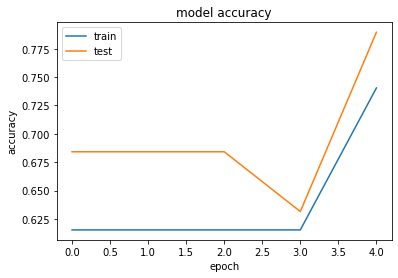

In [ ]:
# Plot accuracy curve
plt.plot(train_acc)
plt.plot(test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

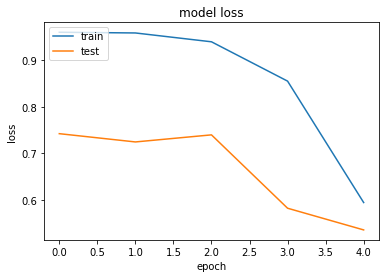

In [ ]:
# Plot loss curve
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Initialize the BERT model again
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Load the weights from the trained model
model.load_state_dict(torch.load(f'/content/drive/MyDrive/email_classification/models/finetuned_BERT_epoch_{epochs}.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Getting predictions
_, predictions, true_vals = evaluate(dataloader_test)

In [ ]:
# Get accuracy per class
accuracy_per_class(predictions, true_vals)

Class: High
Accuracy: 3/4

Class: Medium
Accuracy: 0/2

Class: Low
Accuracy: 13/13



{'accuracy': 0.8421052631578947}

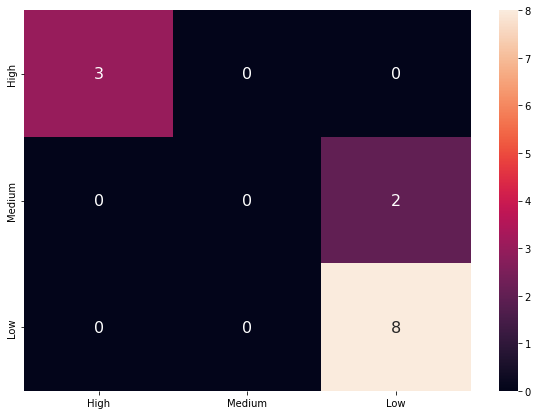

In [ ]:
# Plot Confusion matrix
from sklearn import metrics
matrix = metrics.confusion_matrix(true_vals, predictions.argmax(axis=1))
l = ['High', 'Medium', 'Low']
df_cm = pd.DataFrame(matrix, index = [i for i in l],
                  columns = [i for i in l])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

In [ ]:
# Get classification report
classReport = metrics.classification_report(true_vals, predictions.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

        High       1.00      1.00      1.00         3
      Medium       0.00      0.00      0.00         2
         Low       0.80      1.00      0.89         8

    accuracy                           0.85        13
   macro avg       0.60      0.67      0.63        13
weighted avg       0.72      0.85      0.78        13

